### Second Home Assignment - Prospecção de Dados 2021/2022
#### Group nº 9: Filipe Paulino, 57443; Francisco Carvalho, 40171; Luís Santos, 57470


### 0.1 - Libraries import

In [7]:
# general
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score,mean_squared_error
import time
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# part 1
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectFromModel

# part 2
from sklearn.decomposition import PCA,KernelPCA
from sklearn.svm import SVR

# part 3
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

### 0.2 - Load data

In [8]:
df = pd.read_csv("train.csv")

### 1.1 Preparing data and preprocessing

In [9]:
Xpd = df.drop(columns='critical_temp')
ypd = df['critical_temp']

### 1 - Identify the most important features in descending order of importance

In [4]:
X_train, X_test, y_train, y_test = train_test_split(Xpd, ypd, test_size=0.33, random_state=42)
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

In [5]:
def naif_model_testing(X_train, X_test, y_train, y_test):
    #test 3 approaches and print out the results
    
    rfr= RandomForestRegressor(n_estimators=100)
    rfr.fit(X_train, y_train)

    dtr= DecisionTreeRegressor(max_depth=5)
    dtr.fit(X_train, y_train)

    lmr=LinearRegression()
    lmr.fit(X_train, y_train)

    rf_preds=rfr.predict(X_test)
    dt_preds=dtr.predict(X_test)
    lr_preds=lmr.predict(X_test)

    print("RVE RFs: %7.4f" % explained_variance_score(y_test, rf_preds))
    print("RVE DTs: %7.4f" % explained_variance_score(y_test, dt_preds))
    print("RVE LRs: %7.4f" % explained_variance_score(y_test, lr_preds))

    return explained_variance_score(y_test, rf_preds), explained_variance_score(y_test, dt_preds), explained_variance_score(y_test, lr_preds)


### Using RFs for feature selection

In [20]:
threshold_list = [0.01, 0.05, 0.1]

rve_rffs_rf_list=[]
rve_rffs_dt_list=[]
rve_rffs_lr_list=[]
for i in threshold_list:
    rfr=RandomForestRegressor(random_state=42)
    sel = SelectFromModel(estimator=rfr, threshold= i)
    sel.fit(X_train, y_train)
    
    
    print("Default threshold: ", sel.threshold_)
    
    features=sel.get_support()
    Features_selected =np.arange(M)[features]
    print("The features selected are columns: ", Features_selected)
    
    nX_train=sel.transform(X_train)
    nX_test=sel.transform(X_test)
    rve=naif_model_testing(nX_train, nX_test, y_train, y_test)
    rve_rffs_rf_list.append(rve[0])
    rve_rffs_dt_list.append(rve[1])
    rve_rffs_lr_list.append(rve[2])

Default threshold:  0.01
The features selected are columns:  [ 9 31 43 50 64 66 67 72 74]
RVE RFs:  0.9083
RVE DTs:  0.7628
RVE LRs:  0.5513
Default threshold:  0.05
The features selected are columns:  [64 67]
RVE RFs:  0.7090
RVE DTs:  0.6965
RVE LRs:  0.4787
Default threshold:  0.1
The features selected are columns:  [64 67]
RVE RFs:  0.7087
RVE DTs:  0.6964
RVE LRs:  0.4787


### 2 - Dimensionality reduction

In [8]:
# X_train, X_test, y_train, y_test = train_test_split(Xpd.values, ypd.values, test_size=0.33, random_state=42)

X_train = Xpd.values
y_train = ypd.values

ss_scaler = StandardScaler()
ss_scaler = ss_scaler.fit(X_train)
X_train = ss_scaler.transform(X_train)

#### 2.1 - PCA

In [23]:
pca = PCA()
pca.fit(X_train)

print("Variance explained using the first 10 components: ",\
    pca.explained_variance_ratio_[0:10])
# print("Actual Eigenvalues:", pca.singular_values_)
# for i,comp in enumerate(pca.components_):
#     print("PC",i, "-->", comp)

Variance explained using the first 10 components:  [6.25483991e-01 2.97979287e-01 4.88187332e-02 1.05162732e-02
 8.52720004e-03 5.26716072e-03 1.49998536e-03 7.79888278e-04
 4.30715874e-04 2.09262005e-04]


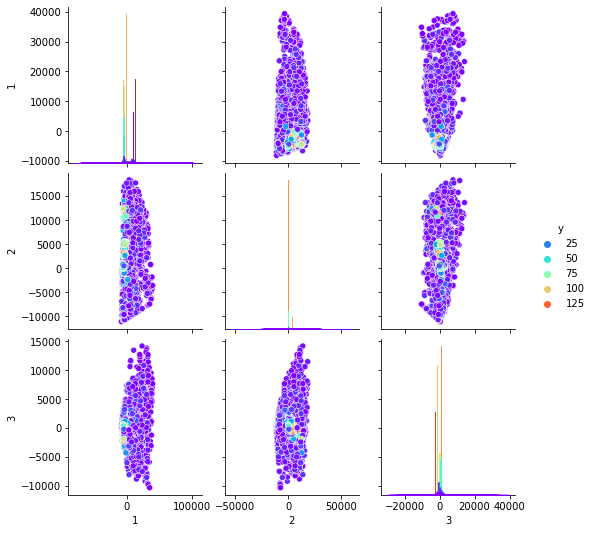

In [24]:
import warnings
warnings.filterwarnings("ignore")
N_COMP = 3
PC_values = list(np.arange(N_COMP) + 1)
PC_values.append('y')

nX_train = pca.transform(X_train)
PCpd = pd.DataFrame(data=np.concatenate((nX_train[:,:N_COMP], y_train.reshape(-1,1)), axis=1), columns=PC_values)

sns.pairplot(
    data=PCpd,
    hue=PCpd.columns[-1],
    palette="rainbow"
    # plot_kws={'scatter_kws': {'alpha': 0.1}}
    )

##### Scree plot

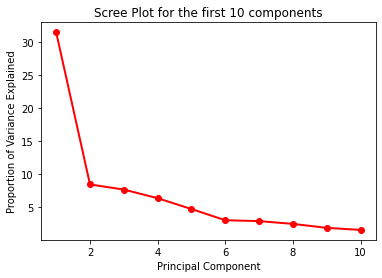

In [9]:
PC_values = np.arange(pca.n_components_) + 1

plt.plot(PC_values[0:10], pca.explained_variance_[0:10], 'ro-', linewidth=2)
plt.title('Scree Plot for the first 10 components')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [10]:
slope_arr= []
for i,v in enumerate(pca.explained_variance_):
    if i+1<len(pca.explained_variance_):
        slope_arr.append(pca.explained_variance_[i+1]-pca.explained_variance_[i])

for i,v in enumerate(slope_arr):
    if i>0 and slope_arr[i]<slope_arr[i-1]:
        n_comp_selec_scree = i-1
        break

print("Number of components retained following scree plot rule: ",\
    n_comp_selec_scree)

Number of components retained following scree plot rule:  1


##### Cumulative variance

Cumulative Prop. Variance Explained:  [0.38931798 0.49414007 0.58935207 0.66842937 0.7272512  0.76513489
 0.8013574  0.83242847 0.8560396  0.87581839]
Number of components retained to explain at least 70% of variance:  5


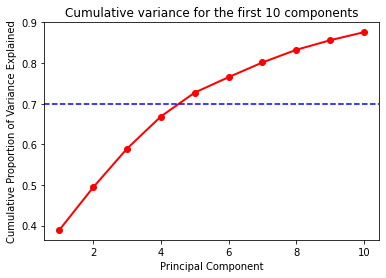

In [11]:
out_sum = np.cumsum(pca.explained_variance_ratio_)

n_comp_selec_variance = next(i for i,v in enumerate(out_sum) if v > 0.7) + 1

# print ("Proportion of Variance Explained : ", pca.explained_variance_ratio_) 
print("Cumulative Prop. Variance Explained: ", out_sum[0:10])
print("Number of components retained to explain at least 70% of variance: ",\
    n_comp_selec_variance)

PC_values = np.arange(pca.n_components_) + 1

plt.plot(PC_values[0:10], out_sum[0:10], 'ro-', linewidth=2)
plt.axhline(y = 0.7, color = 'b', linestyle = '--')
plt.title('Cumulative variance for the first 10 components')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Proportion of Variance Explained')
plt.show()

##### Kaiser rule

In [12]:
n_comp_selec_kaiser = next(i for i,v in enumerate(pca.explained_variance_) if v < 1.0)

print("Number of components retained following kaiser rule: ",\
    n_comp_selec_kaiser)

Number of components retained following kaiser rule:  12


In [13]:
final_comp = np.max([n_comp_selec_scree, n_comp_selec_variance, n_comp_selec_kaiser])

In [14]:
out_sum = np.cumsum(pca.explained_variance_ratio_[0:final_comp])

print("Percentage of variance explained: ",\
    out_sum[final_comp-1])

Percentage of variance explained:  0.9086880346715115


### 3 - Identify the best model with the minimal set of features or dimensions

In [10]:
#Define values for hyperparameters
learning_rate = np.arange(0.2,1.0,0.5)
n_estimators = [150,175]
loss_ADAR = ['linear', 'square', 'exponential']
min_samples_split = np.arange(2,6,3)
min_samples_leaf = np.arange(1,6,3)
max_depth = np.arange(8,35,6)


In [11]:
#Hyperparms Gradient Boosting Regression
params_GRB = {
                'model__learning_rate':learning_rate,
                'model__n_estimators':n_estimators,
                }

GRB = {'GradientBoostingRegressor':GradientBoostingRegressor(random_state=42),'params':params_GRB}

#Hyperparms AdaBoost Regressor
params_ADAR = {
                'model__n_estimators':n_estimators,
                'model__learning_rate':learning_rate,
                'model__loss':loss_ADAR
    
}
ADAR = {'AdaBoostRegressor':AdaBoostRegressor(random_state=42),'params':params_ADAR}

#Hyperparms Decision Trees Regressor
params_DTR = {
                'model__min_samples_split':min_samples_split,
                'model__min_samples_leaf':min_samples_leaf,
                'model__max_depth':max_depth
            }

DTR = {'DecisionTreeRegressor':DecisionTreeRegressor(random_state=42),'params':params_DTR}

#Hyperparms Random Forest Regressor
params_RFR = {
                'model__n_estimators':n_estimators,
                'model__max_depth':max_depth
}

RFR = {'RandomForestRegressor':RandomForestRegressor(random_state=42,n_jobs=-1),'params':params_RFR}

#Linear Regression
LR = {'LinearRegression':LinearRegression()}

In [12]:
#Define list of models to be trained
models = [GRB,ADAR,DTR,RFR,LR]
#models = [LR]

In [13]:
def train_test_model(model,X,y,is_pca,params=None):
    if is_pca:
        pipe = Pipeline([('scaler',StandardScaler()),('pca',PCA(n_components=12)),('model',model)])
        n_comps= pipe.named_steps['pca'].n_components
    else:
        n_comps = None
        pipe = Pipeline([('scaler',StandardScaler()),('model',model)])
    
    print()
    
    if params:
        clf = GridSearchCV(pipe,params,scoring='explained_variance',n_jobs=-1) #Default is 5-fold cv
        clf.fit(X,y)
        return clf.cv_results_,n_comps
    else:
        cv = cross_validate(pipe,X,y,scoring='explained_variance') #Default is 5-fold cv
        return cv,n_comps

In [ ]:
log = []
features_selected = [ 9,31,43,50,64,66,67,72,74]
n_features = len(features_selected)
columns = Xpd.columns[features_selected]
data = [{"X":Xpd.values,"y":ypd.values,"is_comp":True, "is_feature":False},
        {"X":Xpd[columns].values,"y":ypd.values,"is_comp":False,"is_feature":True}]
#loop through dict of models
for d, dataset in enumerate(data):
    X = dataset['X']
    y = dataset['y']
    #print(X)
    for i in range(len(models)):
        print(models[i])
        model_name = list(models[i].keys())[0]
        model = models[i][list(models[i].keys())[0]]

        if list(models[i].keys())[0] == 'LinearRegression':
            res,n_comps = train_test_model(model,X,y,dataset["is_comp"])
            info = {'model':model,
                    'RVE':np.mean(res['test_score']),
                    'hyperparams':'None',
                    'components':n_comps if dataset['is_comp'] else 'None',
                    'features':n_features if dataset['is_feature'] else 'None'}
            log.append(info)
        
        else:
            params = models[i][list(models[i].keys())[1]]
            res,n_comps = train_test_model(model,X,y,dataset["is_comp"],params)

            for j in range(len(res['mean_test_score'])):
                info = {'model':model_name,
                        'RVE':res['mean_test_score'][j],
                        'hyperparams':res['params'][j],
                        'components':n_comps if dataset['is_comp'] else 'None',
                        'features':n_features if dataset['is_feature'] else 'None'}
                log.append(info)

In [15]:
df = pd.DataFrame(log)
top_models = df.sort_values(by=['RVE'],ascending=False).head(10).reset_index(drop=True)
arr = top_models['hyperparams'].values
           
for i,dict_ in enumerate(arr):
    hyperparms = list()
    for (key,value) in dict_.items():
        key_arr = key.split("__")
        hyperparms.append('{}={}'.format(key_arr[1],value))
    top_models.loc[i,'hyperparams'] = str(hyperparms)

#### Top 10 Models

In [16]:
top_models

model       RVE  \
0      RandomForestRegressor  0.722222   
1      RandomForestRegressor  0.721809   
2      RandomForestRegressor  0.721470   
3      RandomForestRegressor  0.721233   
4      RandomForestRegressor  0.721028   
5      RandomForestRegressor  0.720518   
6      RandomForestRegressor  0.720273   
7      RandomForestRegressor  0.719983   
8  GradientBoostingRegressor  0.679147   
9  GradientBoostingRegressor  0.677465   

                                 hyperparams components features  
0       ['max_depth=20', 'n_estimators=150']       None        9  
1       ['max_depth=20', 'n_estimators=175']       None        9  
2       ['max_depth=26', 'n_estimators=150']       None        9  
3       ['max_depth=32', 'n_estimators=150']       None        9  
4       ['max_depth=14', 'n_estimators=150']       None        9  
5       ['max_depth=32', 'n_estimators=175']       None        9  
6       ['max_depth=26', 'n_estimators=175']       None        9  
7       ['max_depth=14', 'n_estimators=175']       None        9  
8  ['learning_rate=0.2', 'n_estimators=175']       None        9  
9  ['learning_rate=0.2', 'n_estimators=150']       None        9